### AMS 520 Kernel Learning Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import sys
from datetime import datetime
import pandas as pd
import numpy as np
from datetime import datetime
import collections
from itertools import chain
from matplotlib.dates import DateFormatter
path='/home/jbohn/jupyter/personal/sbu/Kernel_Learning'

sys.path.append(path)

# Data Set
- Trade and Quote Data for AAPL on NASDAQ between 01/01/2020 and 01/30/2020

### Preprocessing
- Removed trades outside of market hours


In [2]:
def clean_trades(trades):
    trades.index = pd.to_datetime(trades["Time"].values)
    

    trades["date"] = trades.index.date
    
    trades=trades[trades['Trade_Volume']>0]

    grouped_trades = trades.groupby("date").groups

    # drop trade data outside of market hours

    for day in grouped_trades.keys():
        subset = trades[trades["date"] == day]
        grouped_trades[day] = subset[
            subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
        ]
        grouped_trades[day] = subset[
            subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
        ]

    new_trades = pd.concat(list(grouped_trades.values())).sort_index()

    return new_trades


def clean_quotes(quotes, drop_after_hours=True):
    quotes.index = pd.to_datetime(quotes["Time"].values)
    
    quotes=quotes[quotes['Offer_Price']>quotes['Bid_Price']] # removed quotes with invalid spreads 
    
    quotes=quotes[quotes['Bid_Price']>0] # bid and offer price >0

    # drop after hours for quotes, preserve if want to prepend lob
    if drop_after_hours:
        quotes["date"] = quotes.index.date

        grouped_quotes = quotes.groupby("date").groups

        # drop trade data outside of market hours

        for day in grouped_quotes.keys():
            subset = quotes[quotes["date"] == day]
            grouped_quotes[day] = subset[
                subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
            ]
            grouped_quotes[day] = subset[
                subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
            ]
        new_quotes = pd.concat(list(grouped_quotes.values())).sort_index()
        
        return new_quotes
    else:
        return quotes


### Trade Features

In [3]:
trades=pd.read_csv(f"{path}/data/AAPL_trades.csv")
trades=clean_trades(trades)
trades.index=trades['Time']
trades=trades.drop(columns=trades.columns[:2])
trades.sort_index()

,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,date
Time,,,,,,,
2020-01-02 09:30:00.624116,N,AAPL,50,296.23,@ I,N,2020-01-02
2020-01-02 09:30:00.836409,N,AAPL,22,296.25,@ I,N,2020-01-02
2020-01-02 09:30:01.073828,N,AAPL,31,296.26,@ I,N,2020-01-02
2020-01-02 09:30:01.261512,N,AAPL,3,296.27,@ I,N,2020-01-02
2020-01-02 09:30:01.294279,N,AAPL,31,296.25,@ I,N,2020-01-02
...,...,...,...,...,...,...,...
2020-01-29 15:59:53.741022,N,AAPL,200,324.19,@,N,2020-01-29
2020-01-29 15:59:54.202375,N,AAPL,7,324.20,@F I,N,2020-01-29
2020-01-29 15:59:54.211587,N,AAPL,18,324.15,@F I,N,2020-01-29


In [8]:
sample_trades=trades[trades.index<"2020-01-03"]
sample_trades.index=pd.to_datetime(sample_trades.index)

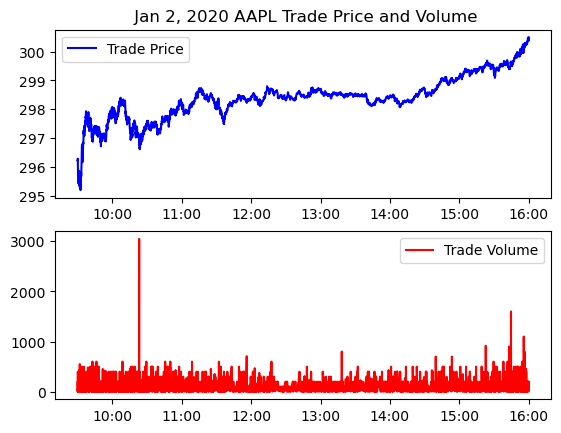

In [20]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_trades["Trade_Price"],label='Trade Price',color='blue')
ax[1].plot(sample_trades["Trade_Volume"],label='Trade Volume',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Trade Price and Volume")
ax[0].legend()
ax[1].legend()

### Examine properties of Trades
    - @ : Regular Trade
    - @F : Regular Intermarket Sweep
    - @I : Regular Odd Lot
    - @IF: Regular Odd Lot Intermarket Sweep

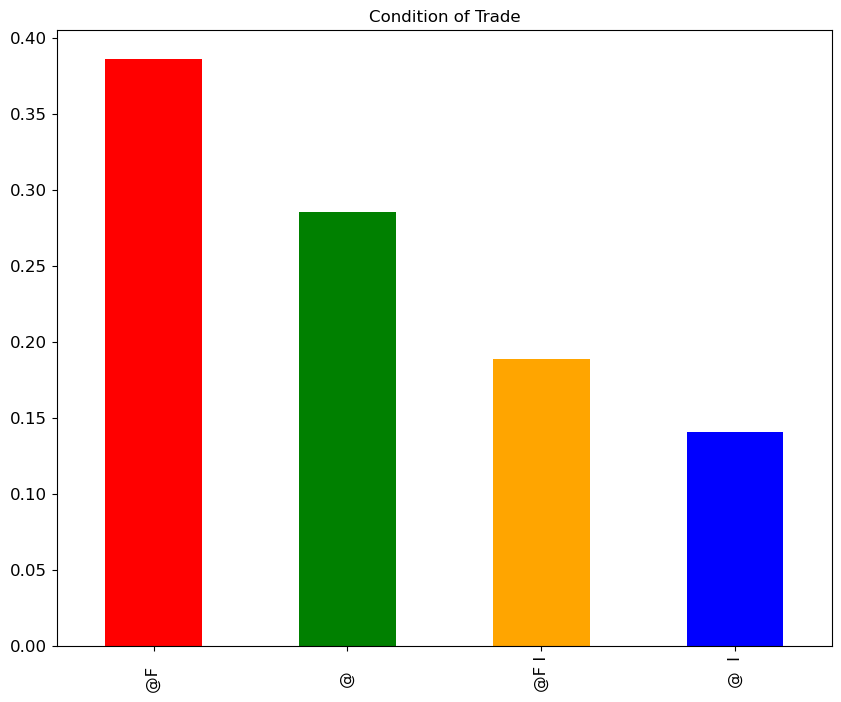

In [24]:
my_colors = c = ['red', 'green', 'orange', 'blue']
ax = (trades['Sale_Condition'].value_counts()/trades.shape[0]).plot(kind='bar', title ="Condition of Trade", figsize=(10,8),  fontsize=12,color=my_colors)

(array([6.7410e+03, 3.8380e+03, 5.4600e+03, 7.3990e+03, 1.2732e+04,
        6.9755e+04, 7.5770e+03, 4.0200e+02, 1.3000e+01, 3.0000e+00]),
 array([0.        , 0.90962754, 1.81925508, 2.72888262, 3.63851017,
        4.54813771, 5.45776525, 6.36739279, 7.27702033, 8.18664787,
        9.09627542]),
 <BarContainer object of 10 artists>)

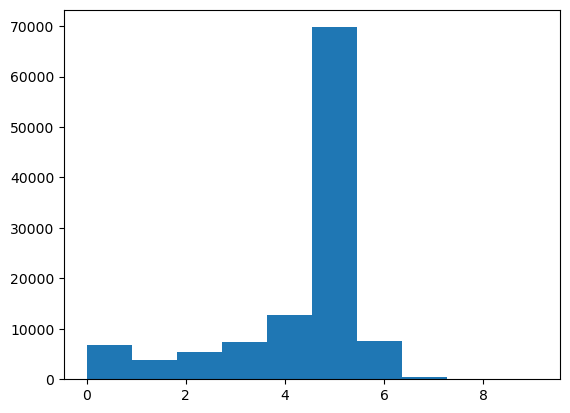

In [6]:
plt.hist(np.log(trades['Trade_Volume']))

### Quote Features


In [47]:
quotes=pd.read_csv(f"{path}/data/AAPL_quotes.csv")
quotes=clean_quotes(quotes)
quotes.index=quotes['Time']
quotes=quotes.drop(columns=quotes.columns[:2])
quotes['Time']=quotes.index
quotes=quotes.dropna(axis=1,how='all')

In [48]:
quotes

,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,Source_Of_Quote,Best_Bid_Exchange,...,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,Participant_Timestamp,FINRA_ADF_Timestamp,Security_Status_Indicator,date,Time
Time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:03.297207,N,AAPL,295.70,1.0,296.75,6.0,R,37,N,Q,...,2.0,Z,296.26,2.0,A,75001344,0,,2020-01-02,2020-01-02 09:30:03.297207
2020-01-02 09:30:05.489581,N,AAPL,296.14,4.0,296.75,5.0,R,109,N,N,...,4.0,Z,296.19,4.0,A,2267377152,0,,2020-01-02,2020-01-02 09:30:05.489581
2020-01-02 09:30:05.664062,N,AAPL,295.70,1.0,296.75,5.0,R,140,N,Q,...,1.0,Z,296.16,2.0,A,2441856512,0,,2020-01-02,2020-01-02 09:30:05.664062
2020-01-02 09:30:06.279237,N,AAPL,294.05,1.0,296.12,2.0,R,130,N,Q,...,1.0,Z,296.07,4.0,A,3057030912,0,,2020-01-02,2020-01-02 09:30:06.279237
2020-01-02 09:30:14.711372,N,AAPL,295.12,1.0,295.74,1.0,R,167,N,Z,...,6.0,N,295.74,1.0,A,2899234816,0,,2020-01-02,2020-01-02 09:30:14.711372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175774,N,AAPL,300.41,2.0,300.66,1.0,R,81,N,Z,...,3.0,Q,300.44,4.0,A,3797782272,0,,2020-01-02,2020-01-02 15:59:41.175774
2020-01-02 15:59:46.114358,N,AAPL,300.29,3.0,300.46,1.0,R,24,N,Z,...,2.0,P,300.46,2.0,A,146432256,0,,2020-01-02,2020-01-02 15:59:46.114358
2020-01-02 15:59:50.119320,N,AAPL,300.29,3.0,300.66,1.0,R,171,N,Q,...,3.0,Q,300.40,4.0,A,4151391744,0,,2020-01-02,2020-01-02 15:59:50.119320


In [49]:
sample_quotes=quotes[quotes.index<"2020-01-03"]
sample_quotes.index=pd.to_datetime(sample_quotes.index)

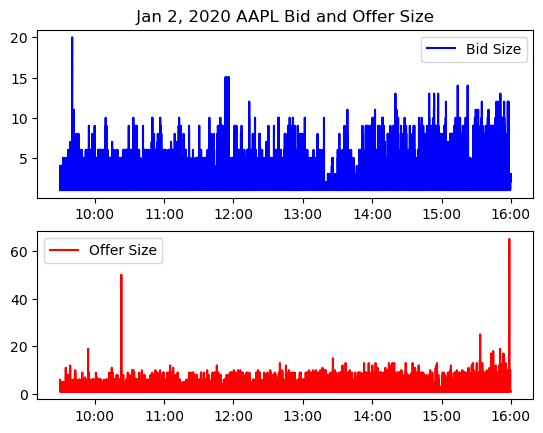

In [27]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_quotes['Bid_Size'],label='Bid Size',color='blue')
ax[1].plot(sample_quotes['Offer_Size'],label='Offer Size',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Bid and Offer Size ")
ax[0].legend()
ax[1].legend()

In [13]:
bid_percent=(quotes['Bid_Price']>=quotes['Best_Bid_Price']).sum()/len(quotes['Bid_Price'])
ask_percent=(quotes['Offer_Price']<=quotes['Best_Offer_Price']).sum()/len(quotes['Offer_Price'])

print (bid_percent,ask_percent)

0.49824441013324183 0.5702407502716303


In [35]:
quotes['Offer_Size'].std()

1.687642352769863

In [43]:
(quotes['Offer_Size'].values[1:]-quotes['Offer_Size'].values[:-1]).std()

1.6204842792478449

In [36]:
quotes['Bid_Size'].std()

1.456579941924296

In [45]:
(quotes['Bid_Size'].values[1:]-quotes['Bid_Size'].values[:-1]).mean()

2.287439668778736e-05

In [37]:
(quotes['Offer_Price']-quotes['Bid_Price']).std()

0.10685685635390055

### Construct LOB

In [18]:


column_funcs={'Exchange':'last','Symbol':'last','Bid_Price':np.mean,'Bid_Size':np.sum,'Offer_Price':np.mean,'Offer_Size':np.sum,'Best_Bid_Exchange':'last','Best_Bid_Price':'last','Best_Bid_Size':'last','Best_Offer_Exchange':'last','Best_Offer_Price':'last','Best_Offer_Size':'last'}
quotes=quotes.groupby(quotes.index).agg(column_funcs)

# construct LOB at time t via looback period of some duration (i.e. 1000)
quotes['Bid_Price_Nested']=[quotes['Bid_Price'].values[max(i-500,0):i+1] for i in range(0,quotes.shape[0])]
quotes['Bid_Sizes_Nested']=[quotes['Bid_Size'].values[max(i-500,0):i+1] for i in range(0,quotes.shape[0])]

 
# use best bid on queried exchange as benchmark for removing stale quotes
quotes['Best_Bid_Price_Exchange']=quotes['Best_Bid_Price'][quotes['Best_Bid_Exchange']==np.unique(quotes['Exchange'].values)[0]]  # benchmark on best bid same exchange
quotes['Best_Bid_Price_Exchange']=quotes['Best_Bid_Price_Exchange'].fillna(np.inf)

#take best bid as the min between highest bid that is less than quoted offer and  bbo across all exchanges 
quotes['Best_Bid_Price_Exchange']=[min(np.max(np.concatenate([quotes['Bid_Price_Nested'].values[i],np.array([0])])),quotes['Best_Bid_Price_Exchange'].values[i],quotes['Offer_Price'].values[i]-0.01) for i in range (0,quotes.shape[0])]
 
# remove stale bids or asks that violate BBO
quotes['Bid_Sizes_Nested']=[quotes['Bid_Sizes_Nested'].values[i][quotes['Bid_Price_Nested'].values[i]<=quotes['Best_Bid_Price_Exchange'].values[i]] for i in range (0,quotes.shape[0])]
quotes['Bid_Price_Nested']=[quotes['Bid_Price_Nested'].values[i][quotes['Bid_Price_Nested'].values[i]<=quotes['Best_Bid_Price_Exchange'].values[i]] for i in range (0,quotes.shape[0])]


 
### reformulate into dictionary 
quotes['Bid_Book']=[dict(zip(quotes['Bid_Price_Nested'].values[i],quotes['Bid_Sizes_Nested'].values[i])) for i in range (0,quotes.shape[0])]


# sort bid prices and construct LOB up to lvl n 
quotes['Bid_Book_n']=[list(chain.from_iterable(list(collections.OrderedDict(sorted(i.items(),reverse=True)).items())[-3:])) for i in quotes['Bid_Book'].values]


# construct LOB at time t via looback period of some duration (i.e. 1000)
quotes['Offer_Price_Nested']=[quotes['Offer_Price'].values[max(i-500,0):i+1] for i in range(0,quotes.shape[0])]
quotes['Offer_Sizes_Nested']=[quotes['Offer_Size'].values[max(i-500,0):i+1] for i in range(0,quotes.shape[0])]


# use best bid on queried exchange as benchmark for removing stale quotes
quotes['Best_Offer_Price_Exchange']=quotes['Best_Offer_Price'][quotes['Best_Offer_Exchange']==np.unique(quotes['Exchange'].values)[0]] # assumes one exchange
quotes['Best_Offer_Price_Exchange']=quotes['Best_Offer_Price_Exchange'].fillna(-np.inf)

#take offer as lowest ask on our exchange greater than quoted bid and bbo across all exchanges 
quotes['Best_Offer_Price_Exchange']=[max(np.min(np.concatenate([quotes['Offer_Price_Nested'].values[i],np.array([np.inf])])),quotes['Best_Offer_Price_Exchange'].values[i],quotes['Bid_Price'].values[i]+0.01) for i in range (0,quotes.shape[0])]


# remove stale bids or asks that violate BBO
quotes['Offer_Sizes_Nested']=[quotes['Offer_Sizes_Nested'].values[i][quotes['Offer_Price_Nested'].values[i]>=quotes['Best_Offer_Price_Exchange'].values[i]] for i in range (0,quotes.shape[0])]
quotes['Offer_Price_Nested']=[quotes['Offer_Price_Nested'].values[i][quotes['Offer_Price_Nested'].values[i]>=quotes['Best_Offer_Price_Exchange'].values[i]] for i in range (0,quotes.shape[0])]

### reformulate into dictionary 
quotes['Offer_Book']=[dict(zip(quotes['Offer_Price_Nested'].values[i],quotes['Offer_Sizes_Nested'].values[i])) for i in range (0,quotes.shape[0])]


# sort bid prices and construct LOB up to lvl n 
quotes['Offer_Book_n']=[list(chain.from_iterable(list(collections.OrderedDict(sorted(i.items())).items())[:3])) for i in quotes['Offer_Book'].values]

In [19]:
quotes

,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Best_Bid_Exchange,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,...,Bid_Price_Nested,Bid_Sizes_Nested,Best_Bid_Price_Exchange,Bid_Book,Bid_Book_n,Offer_Price_Nested,Offer_Sizes_Nested,Best_Offer_Price_Exchange,Offer_Book,Offer_Book_n
Time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:03.297207,N,AAPL,295.70,1.0,296.75,6.0,Q,296.19,2.0,Z,...,[295.7],[1.0],295.70,{295.7: 1.0},"[295.7, 1.0]",[296.75],[6.0],296.75,{296.75: 6.0},"[296.75, 6.0]"
2020-01-02 09:30:05.489581,N,AAPL,296.14,4.0,296.75,5.0,N,296.14,4.0,Z,...,"[295.7, 296.14]","[1.0, 4.0]",296.14,"{295.7: 1.0, 296.14: 4.0}","[296.14, 4.0, 295.7, 1.0]","[296.75, 296.75]","[6.0, 5.0]",296.75,{296.75: 5.0},"[296.75, 5.0]"
2020-01-02 09:30:05.664062,N,AAPL,295.70,1.0,296.75,5.0,Q,296.13,1.0,Z,...,"[295.7, 296.14, 295.7]","[1.0, 4.0, 1.0]",296.14,"{295.7: 1.0, 296.14: 4.0}","[296.14, 4.0, 295.7, 1.0]","[296.75, 296.75, 296.75]","[6.0, 5.0, 5.0]",296.75,{296.75: 5.0},"[296.75, 5.0]"
2020-01-02 09:30:06.279237,N,AAPL,294.05,1.0,296.12,2.0,Q,296.03,1.0,Z,...,"[295.7, 295.7, 294.05]","[1.0, 1.0, 1.0]",296.11,"{295.7: 1.0, 294.05: 1.0}","[295.7, 1.0, 294.05, 1.0]","[296.75, 296.75, 296.75, 296.12]","[6.0, 5.0, 5.0, 2.0]",296.12,"{296.75: 5.0, 296.12: 2.0}","[296.12, 2.0, 296.75, 5.0]"
2020-01-02 09:30:14.711372,N,AAPL,295.12,1.0,295.74,1.0,Z,295.65,6.0,N,...,"[295.7, 295.7, 294.05, 295.12]","[1.0, 1.0, 1.0, 1.0]",295.73,"{295.7: 1.0, 294.05: 1.0, 295.12: 1.0}","[295.7, 1.0, 295.12, 1.0, 294.05, 1.0]","[296.75, 296.75, 296.75, 296.12, 295.74]","[6.0, 5.0, 5.0, 2.0, 1.0]",295.74,"{296.75: 5.0, 296.12: 2.0, 295.74: 1.0}","[295.74, 1.0, 296.12, 2.0, 296.75, 5.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175774,N,AAPL,300.41,2.0,300.66,1.0,Z,300.41,3.0,Q,...,"[300.26, 300.26, 300.26, 300.23, 300.21, 300.2...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",300.42,"{300.26: 2.0, 300.23: 2.0, 300.21: 2.0, 300.24...","[300.17, 2.0, 300.11, 1.0, 300.08, 1.0]","[300.48, 300.48, 300.46, 300.46, 300.46, 300.5...","[1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 10.0, 1.0, 1.0,...",300.42,"{300.48: 1.0, 300.46: 1.0, 300.51: 10.0, 300.6...","[300.44, 1.0, 300.46, 1.0, 300.48, 1.0]"
2020-01-02 15:59:46.114358,N,AAPL,300.29,3.0,300.46,1.0,Z,300.44,2.0,P,...,"[300.26, 300.26, 300.23, 300.21, 300.21, 300.2...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",300.42,"{300.26: 2.0, 300.23: 2.0, 300.21: 2.0, 300.24...","[300.17, 2.0, 300.11, 1.0, 300.08, 1.0]","[300.48, 300.48, 300.3, 300.3, 300.3, 300.3, 3...","[1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",300.30,"{300.48: 1.0, 300.3: 2.0, 300.37: 4.0, 300.34:...","[300.3, 2.0, 300.31, 2.0, 300.34, 7.0]"
2020-01-02 15:59:50.119320,N,AAPL,300.29,3.0,300.66,1.0,Q,300.37,3.0,Q,...,"[300.26, 300.23, 300.21, 300.21, 300.24, 300.2...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",300.42,"{300.26: 2.0, 300.23: 2.0, 300.21: 2.0, 300.24...","[300.17, 2.0, 300.11, 1.0, 300.08, 1.0]","[300.48, 300.48, 300.3, 300.3, 300.3, 300.3, 3...","[1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",300.30,"{300.48: 1.0, 300.3: 2.0, 300.37: 4.0, 300.34:...","[300.3, 2.0, 300.31, 2.0, 300.34, 7.0]"


In [20]:
bid_df=pd.DataFrame(quotes['Bid_Book_n'])
columns=np.array(list(chain.from_iterable([(f'Bid_Size_{2-i}',f'Bid_Price_{2-i}') for i in range(0,3)])))[::-1]

bid_df=pd.DataFrame(bid_df['Bid_Book_n'].values.tolist(),index=bid_df.index,columns=columns)

In [21]:
offer_df=pd.DataFrame(quotes['Offer_Book_n'])
columns=list(chain.from_iterable([(f'Offer_Price_{i}',f'Offer_Size_{i}') for i in range(0,3)]))

offer_df=pd.DataFrame(offer_df['Offer_Book_n'].values.tolist(),index=offer_df.index,columns=columns) 

In [22]:
lob=pd.concat([bid_df[bid_df.columns[::-1]],offer_df]).sort_index()
lob=lob.ffill().dropna()
lob.groupby(lob.index).mean() # average out identical times 

,Bid_Size_2,Bid_Price_2,Bid_Size_1,Bid_Price_1,Bid_Size_0,Bid_Price_0,Offer_Price_0,Offer_Size_0,Offer_Price_1,Offer_Size_1,Offer_Price_2,Offer_Size_2
Time,,,,,,,,,,,,
2020-01-02 09:30:14.711372,1.0,294.05,1.0,295.12,1.0,295.70,295.74,1.0,296.12,2.0,296.75,5.0
2020-01-02 09:30:14.712400,1.0,294.05,1.0,295.12,1.0,295.70,295.74,1.0,295.81,2.0,296.12,2.0
2020-01-02 09:30:17.317694,1.0,294.05,1.0,295.12,1.0,295.57,295.63,1.0,295.74,1.0,295.81,2.0
2020-01-02 09:30:28.784561,1.0,294.05,1.0,295.12,1.0,295.44,295.68,1.0,295.74,1.0,295.81,2.0
2020-01-02 09:30:28.784958,1.0,294.05,1.0,295.12,1.0,295.44,295.63,1.0,295.68,2.0,295.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175774,1.0,300.08,1.0,300.11,2.0,300.17,300.44,1.0,300.46,1.0,300.48,1.0
2020-01-02 15:59:46.114358,1.0,300.08,1.0,300.11,2.0,300.17,300.30,2.0,300.31,2.0,300.34,7.0
2020-01-02 15:59:50.119320,1.0,300.08,1.0,300.11,2.0,300.17,300.30,2.0,300.31,2.0,300.34,7.0
